In [306]:
import subprocess
import time
import re
import os
import numpy as np
import matplotlib.pyplot as plt
#from scipy.constants import *
from scipy import integrate
import sympy as sp
import shutil
import ase
from ase.io import read
from ase.units import Ang, eV, kg, mol, J, kB, _hplanck, s, GPa
#constants
h=_hplanck *J*s
g=kg/1000
K=1

In [307]:

def generate_input_files(phase,temperature,pressure,seed):
    output_dir=f"{temperature}_{pressure}"
    os.makedirs(output_dir, exist_ok=True)
    path=f"{temperature}_{pressure}"
    in_file = f"{path}/in.{phase}"
    sh_file = f"{path}/{phase}.sh"
    with open(in_file, "w") as f:
        f.write("units           metal \n")
        f.write("dimension       3\n")
        f.write("boundary        p p p\n")
        f.write("atom_style      atomic\n")
        f.write(f"read_data       ../{phase}.data\n")
        f.write("labelmap atom 1 H 2 N 3 F\n")
        f.write("mass            1 1.008000\n")
        f.write("mass            2 14.00700\n")
        f.write("mass            3 18.99800\n")
        f.write("pair_style deepmd /home/Share/XZ/MLP/model-compress-pbe.pb\n")
        f.write("pair_coeff * * H N F\n")
        f.write("neighbor        2.0 bin\n")
        f.write("neigh_modify every 10 delay 0 check yes\n")
        f.write("thermo 10\n")
        f.write(f"dump rundump all custom 2000 ./{phase}.lammpstrj id type x y z\n")
        f.write("dump_modify rundump sort id\n")
        f.write(f"velocity all create {temperature} {seed}  dist gaussian\n")
        f.write(f'fix print_volume all print 10 "$(step) $(enthalpy) $(vol)" file thermo_{phase}.dat screen no title "# step Enthalpy(eV) Volume(A^3)" screen no\n')
        f.write(f"fix 1 all npt temp {temperature} {temperature} 0.1 aniso {pressure} {pressure} 1.0\n")
        f.write("timestep 0.0005\n")
        f.write("run 200000\n")
        f.write(f"write_data ./{phase}.data types labels\n")

    with open(sh_file, "w") as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH -n 16\n')
        f.write('#SBATCH -N 1\n')
        f.write(f"#SBATCH -J {phase}_{temperature}_{pressure}\n")
        f.write('#SBATCH --gres=gpu:1\n')
        f.write('#SBATCH -p NVIDIAGeForceRTX3090\n')
        f.write('#SBATCH -e error.err\n')
        f.write('#SBATCH -o output.out\n')
        f.write('module purge\n')
        f.write('module add apps/lammps/2Aug2023-gpu3080\n')
        f.write(f"lmp -in ./in.{phase} -log {phase}.log")

    return path

def submit_jobs(path,phase):
    job_ids = []
    os.chdir(path)
    for inp in phase:
        cmd = ["sbatch", f"{inp}.sh"]
        result = subprocess.run(cmd, capture_output=True, text=True)
        print(result)
        job_id = result.stdout.strip().split()[-1]  # "Submitted batch job 12345"
        job_ids.append(job_id)
    print(f"Submitted batch job: {job_ids}")
    os.chdir("../")
    return job_ids



def wait_for_jobs(job_ids):
    """轮询等待所有作业完成（用 squeue 检查）"""
    while True:
        cmd = ["squeue", "--jobs", ",".join(job_ids), "--noheader"]
        result = subprocess.run(cmd, capture_output=True, text=True)
        if not result.stdout.strip():  # 无输出表示所有作业完成
            print("###finished###")
            break
        time.sleep(30)  # 每 30 秒检查一次

def get_atom_num(path,filename):
    file_path=f"{path}/{filename}"
    with open(file_path, 'r') as f:
        content = f.read()

    # 正则匹配：开头可选空格 + 数字 + 空格 + atoms
    match = re.search(r'^\s*(\d+)\s+atoms', content, re.MULTILINE)
    atom_count = int(match.group(1))
    return atom_count

def slope_cal(path,phase):
    enthalpy=[]
    volume=[]
    for i in phase:
        data=np.loadtxt(f"{path}/thermo_{i}.dat")[10:]
        nmol=get_atom_num("./",f"{i}.data")/6
        H=np.mean(data[:,1])/nmol
        V=np.mean(data[:,2])/nmol
        enthalpy.append(H)
        volume.append(V)

    print(f"echo Properties phase 1 enthalpy {enthalpy[0]} volume {volume[0]} - phase 2 enthalpy {enthalpy[1]} volume {volume[1]}")
    conversion_factor_bar_eV_Acube=6.241509e-7
    slope=temperature*(volume[0]-volume[1])*conversion_factor_bar_eV_Acube/(enthalpy[0]-enthalpy[1])
    return slope

def flow(phase,temperature,pressure,seed):
    for p in phase:
        path=generate_input_files(p,temperature,pressure,seed)

    job_ids=submit_jobs(path,phase)
    wait_for_jobs(job_ids)
    print(f"echo kx calculation - temperature {temperature} - pressure {pressure}")
    slope=slope_cal(path,phase)
    return slope

def Runge_Kutta(phase,temperature,pressure,P_step,seed):
    k1=flow(phase,temperature,pressure,seed)
    k2=flow(phase,np.round(temperature+0.5*P_step*k1,2),pressure+0.5*P_step,seed)
    k3=flow(phase,np.round(temperature+0.5*P_step*k2),pressure+0.5*P_step,seed)
    k4=flow(phase,np.round(temperature+P_step*k3),pressure+P_step,seed)
    new_pressure=pressure+P_step
    new_temperature=np.round(temperature+(1./6.)*P_step*(k1+2*k2+2*k3+k4))
    return new_pressure,new_temperature


In [ ]:
seed=79887
phase=["Ih","L"]
P_step=-1000  #bar

for loop in range(4):
    with open('thermal_condition.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        if lines:
            last_line = lines[-1].strip()

    pressure, temperature = map(float, last_line.split())

    P,T=Runge_Kutta(phase,temperature,pressure,P_step,seed)
    with open("thermal_condition.txt", "a") as f:
        f.write(f"{P} {T} \n")


In [308]:
#equilibration
def minimization(conf):
    os.makedirs(f"{conf}", exist_ok=True)
    path=f"{conf}/em"
    os.makedirs(f"{path}", exist_ok=True)
    in_file = f"{path}/in.em"
    sh_file = f"{path}/em.sh"
    with open(in_file, "w") as f:
        f.write("units           metal \n")
        f.write("dimension       3\n")
        f.write("boundary        p p p\n")
        f.write("atom_style      atomic\n")
        f.write(f"read_data       {conf}.data\n")
        f.write("labelmap atom 1 H 2 N 3 F\n")
        f.write("mass            1 1.008000\n")
        f.write("mass            2 14.00700\n")
        f.write("mass            3 18.99800\n")
        f.write("pair_style deepmd /home/Share/XZ/MLP/model-compress-pbe.pb\n")
        f.write("pair_coeff * * H N F\n")
        f.write("neighbor        2.0 bin\n")
        f.write("neigh_modify every 10 delay 0 check yes\n")
        f.write("minimize 0.0 1.0e-8 1000 100000\n")
        f.write(f"write_data ./em.data\n")

    with open(sh_file, "w") as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH -n 16\n')
        f.write('#SBATCH -N 1\n')
        f.write(f"#SBATCH -J em\n")
        f.write('#SBATCH --gres=gpu:1\n')
        f.write('#SBATCH -p NVIDIAGeForceRTX3090\n')
        f.write('#SBATCH -e error.err\n')
        f.write('#SBATCH -o output.out\n')
        f.write('module purge\n')
        f.write('module add apps/lammps/2Aug2023-gpu3080\n')
        f.write(f"lmp -in ./in.em -log em.log")

    return path

def gauss_integral_generator(num):
    nodes, weights = np.polynomial.legendre.leggauss(num)
    nodes_transformed = 0.5 * (nodes + 1)
    weights_transformed = weights * 0.5
    lambda_=[]
    weight=[]
    for i in range(num):
        lambda_.append(np.round(nodes_transformed[i],5))
        weight.append(np.round(weights_transformed[i],5))
    return lambda_,weight


In [350]:
#equilibration
def Hamiltonian_integration(conf,TEMP,dp_model,EPSILON=0.02):
    print(f"generating input files at {TEMP} K")
    print(f"Epsilon for LJ parameters: {EPSILON} eV")
    shutil.copy(f"{conf}/em/em.data",f"{conf}/em.data")
    path_lj_on=f"{conf}/1_lj_on"
    os.makedirs(path_lj_on, exist_ok=True)
    
    #lambda1=[1e-8,0.0125,0.025,0.0375,0.05,0.0625,0.075,0.0875,0.1,
    #        0.125,0.15,0.175,0.2,0.4,0.6,0.8,1-1e-8]
    
    lambda1,weight1=gauss_integral_generator(16)
    print(f"LJ on: 16 lambdas are generated for gauss integral method")
    for i in lambda1:
        os.makedirs(f"{path_lj_on}/{i}", exist_ok=True)
        in_file=f"{path_lj_on}/{i}/lj.in"
        sh_file=f"{path_lj_on}/{i}/run.sh"
        
        with open(in_file, "w") as f:
            f.write("#------Variables-------\n")
            f.write(f"variable        EPSILON equal {EPSILON}\n")
            f.write(f"variable        LAMBDA equal {i}\n")
            f.write("#------Initialization-------\n")
            f.write("units           metal \n")
            f.write("dimension       3\n")
            f.write("boundary        p p p\n")
            f.write("atom_style      atomic\n")
            f.write("#------Atom Definition-------\n")
            f.write("box             tilt large\n")
            f.write(f"read_data       {conf}/em.data\n")
            f.write("change_box      all triclinic\n")
            f.write("#labelmap atom 1 H 2 N 3 F\n")
            f.write("mass            1 2.0000\n")
            f.write("mass            2 14.00000\n")
            f.write("mass            3 18.00000\n")
            f.write("#------Force Fields-------\n")
            f.write("#------12-6 Lennard-Jones modified by a soft core-------\n")
            f.write("pair_style lj/cut/soft 1.000000 0.500000 6.000000\n")
            f.write("# lj/cut/soft args = n alpha_lj cutoff\n")
            f.write("# n, alpha_LJ = parameters of soft-core potential\n")
            f.write("# cutoff = global cutoff for Lennard-Jones interactions (distance units)\n")
            f.write("#------Coeff: type type epsilon sigma lambda-------\n")
            f.write("pair_coeff 1 1 ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 2 ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 3 ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 2 2 ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 2 3 ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 3 3 ${EPSILON} 3.15  0.5 #F\n")
            f.write("#------mixed pair_coeff terms from geometric mixing rule-------\n")
            f.write("fix            tot_pot all adapt/fep 0 pair lj/cut/soft epsilon * * v_LAMBDA scale yes\n")
            f.write("#------0:do not change with simulation steps-------\n")
            f.write("#------v_LAMBDA:scaling factor-------\n")
            f.write(f"compute         e_diff all fep {TEMP} pair lj/cut/soft epsilon * * v_EPSILON\n")
            f.write("group           type_1 type 1\n")
            f.write("group           type_2 type 2\n")
            f.write("group           type_3 type 3\n")
            f.write("#------Restraint on atoms, spring constant depends on the atomic number-------\n")
            f.write("fix             l_spring_1 type_1 spring/self 1.0000000000e+00\n")
            f.write("fix_modify      l_spring_1 energy yes\n")
            f.write("fix             l_spring_2 type_2 spring/self 7.0000000000e+00\n")
            f.write("fix_modify      l_spring_2 energy yes\n")
            f.write("fix             l_spring_3 type_3 spring/self 9.0000000000e+00\n")
            f.write("fix_modify      l_spring_3 energy yes\n")
            f.write("#spring energy= k*(r-r0)^2\n")
            f.write("variable        l_spring equal f_l_spring_1+f_l_spring_2+f_l_spring_3\n")
            f.write("#------MD Settings-------\n")
            f.write("neighbor        1.0 bin\n")
            f.write("timestep        0.0005\n")
            f.write("thermo          10\n")
            f.write("compute         allmsd all msd\n")
            f.write("thermo_style    custom step ke pe etotal enthalpy temp press vol v_l_spring c_e_diff[1] c_allmsd[*]\n")
            f.write("thermo_modify   format 9 %.16e\n")
            f.write("thermo_modify   format 10 %.16e\n")
            f.write("dump            1 all custom 100 dump.lammpstrj id type x y z\n")
            f.write("fix             1 all nve\n")
            f.write(f"fix             2 all langevin {TEMP} {TEMP} 0.1 56817 zero yes\n")
            f.write("#------Initialize-------\n")
            f.write(f"velocity        all create {TEMP} 2513\n")    
            f.write("fix             fc all recenter INIT INIT INIT\n") 
            f.write("fix             fm all momentum 1 linear 1 1 1\n")
            f.write("velocity        all zero linear\n")
            f.write("#------Run-------\n")
            f.write("run             200000 \n")
            f.write("write_data      lj-out.data\n")
        
        with open(sh_file, "w") as f:
            f.write('#!/bin/bash\n')
            f.write('#SBATCH -n 16\n')
            f.write('#SBATCH -N 1\n')
            f.write(f"#SBATCH -J {i}_lj\n")
            f.write('#SBATCH --gres=gpu:1\n')
            f.write('#SBATCH -p NVIDIAGeForceRTX3090\n')
            f.write('#SBATCH -e error.err\n')
            f.write('#SBATCH -o output.out\n')
            f.write('module purge\n')
            f.write('module load apps/lammps/23Jun2022\n')
            f.write('module load compiler/intel/2021.3.0 \n')
            f.write('module load compiler/gcc/7.3.1 \n')
            f.write('module load mathlib/fftw/intelmpi/3.3.9_single mpi/intelmpi/2021.3.0 \n')
            f.write('export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/public/software/compiler/intel/2021.3.0/mkl/lib/intel64:/public/software/mpi/intelmpi/2021.3.0/lib:/public/software/compiler/intel/2021.3.0/compiler/lib/intel64_lin:/public/software/compiler/gcc/7.3.1/lib64:/usr/local/cuda-12.1/lib64:/lib64 \n')
            f.write('export PATH=/public/sourcecode/softwares/liudj/lammps-23Jun2022-intel/bin:$PATH \n')
            f.write(f"lmp -in ./lj.in -log lj.log")

    path_dp_on=f"{conf}/2_deep_potential_on"
    os.makedirs(path_dp_on, exist_ok=True)
    
    #lambda2=[1e-8,0.025,0.05,0.075,0.1,0.2125,0.325,
            #0.4375,0.55,0.6625,0.775,0.8875,1-1e-8]
    lambda2,weight2=gauss_integral_generator(12)
    print(f"Deep potential on: 12 lambdas are generated for gauss integral method")
    for i in lambda2:
        os.makedirs(f"{path_dp_on}/{i}", exist_ok=True)
        in_file=f"{path_dp_on}/{i}/dp.in"
        sh_file=f"{path_dp_on}/{i}/run.sh"
        
        with open(in_file, "w") as f:
            f.write("#------Variables-------\n")
            f.write(f"variable        EPSILON equal {EPSILON}\n")
            f.write(f"variable        LAMBDA equal {i}\n")
            f.write(f"variable        ONE equal 1\n")
            f.write("#------Initialization-------\n")
            f.write("units           metal \n")
            f.write("dimension       3\n")
            f.write("boundary        p p p\n")
            f.write("atom_style      atomic\n")
            f.write("#------Atom Definition-------\n")
            f.write("box             tilt large\n")
            f.write(f"read_data       {conf}/em.data\n")
            f.write("change_box      all triclinic\n")
            f.write("#labelmap atom 1 H 2 N 3 F\n")
            f.write("mass            1 2.0000\n")
            f.write("mass            2 14.00000\n")
            f.write("mass            3 18.00000\n")
            f.write("#------Force Fields-------\n")
            f.write("#------12-6 Lennard-Jones modified by a soft core-------\n")
            f.write(f"pair_style hybrid/overlay deepmd {dp_model} lj/cut/soft 1.000000 0.500000 6.000000\n")
            f.write("pair_coeff * * deepmd H N F \n")
            f.write("pair_coeff 1 1 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 2 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 3 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 2 2 lj/cut/soft ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 2 3 lj/cut/soft ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 3 3 lj/cut/soft ${EPSILON} 3.15  0.5 #F\n")
            f.write("#------mixed pair_coeff terms from geometric mixing rule-------\n")
            f.write("fix             tot_pot all adapt/fep 0 pair deepmd scale * * v_LAMBDA\n")
            f.write("#------0:do not change with simulation steps-------\n")
            f.write("#------v_LAMBDA:scaling factor-------\n")
            f.write(f"compute         e_diff all fep {TEMP} pair deepmd scale * * v_ONE\n")
            f.write("group           type_1 type 1\n")
            f.write("group           type_2 type 2\n")
            f.write("group           type_3 type 3\n")
            f.write("#------Restraint on atoms, spring constant depends on the atomic number-------\n")
            f.write("fix             l_spring_1 type_1 spring/self 1.0000000000e+00\n")
            f.write("fix_modify      l_spring_1 energy yes\n")
            f.write("fix             l_spring_2 type_2 spring/self 7.0000000000e+00\n")
            f.write("fix_modify      l_spring_2 energy yes\n")
            f.write("fix             l_spring_3 type_3 spring/self 9.0000000000e+00\n")
            f.write("fix_modify      l_spring_3 energy yes\n")
            f.write("variable        l_spring equal f_l_spring_1+f_l_spring_2+f_l_spring_3\n")
            f.write("#------MD Settings-------\n")
            f.write("neighbor        1.0 bin\n")
            f.write("timestep        0.0005\n")
            f.write("thermo          10\n")
            f.write("compute         allmsd all msd\n")
            f.write("thermo_style    custom step ke pe etotal enthalpy temp press vol v_l_spring c_e_diff[1] c_allmsd[*]\n")
            f.write("thermo_modify   format 9 %.16e\n")
            f.write("thermo_modify   format 10 %.16e\n")
            f.write("dump            1 all custom 100 dump.lammpstrj id type x y z\n")
            f.write("fix             1 all nve\n")
            f.write(f"fix             2 all langevin {TEMP} {TEMP} 0.1 56817 zero yes\n")
            f.write("#------Initialize-------\n")
            f.write(f"velocity        all create {TEMP} 2513\n")    
            f.write("fix             fc all recenter INIT INIT INIT\n") 
            f.write("fix             fm all momentum 1 linear 1 1 1\n")
            f.write("velocity        all zero linear\n")
            f.write("#------Run-------\n")
            f.write("run             200000 \n")
            f.write("write_data      dp-out.data\n")
        
        with open(sh_file, "w") as f:
            f.write('#!/bin/bash\n')
            f.write('#SBATCH -n 16\n')
            f.write('#SBATCH -N 1\n')
            f.write(f"#SBATCH -J {i}_dp\n")
            f.write('#SBATCH --gres=gpu:1\n')
            f.write('#SBATCH -p NVIDIAGeForceRTX3090\n')
            f.write('#SBATCH -e error.err\n')
            f.write('#SBATCH -o output.out\n')
            f.write('module purge\n')
            f.write('module load  apps/lammps/2Aug2023-gpu-dp\n')
            f.write(f"lmp -in ./dp.in -log dp.log")   

            
    path_sp_off=f"{conf}/3_spring_off"
    os.makedirs(path_sp_off, exist_ok=True)
    print(f"Spring off: 12 lambdas are generated for gauss integral method")

    for i in lambda2:
        os.makedirs(f"{path_sp_off}/{i}", exist_ok=True)
        in_file=f"{path_sp_off}/{i}/sp.in"
        sh_file=f"{path_sp_off}/{i}/run.sh"
        j=1-i
        with open(in_file, "w") as f:
            f.write("#------Variables-------\n")
            f.write(f"variable        EPSILON equal {EPSILON}\n")
            f.write(f"variable        INV_EPSILON equal -{EPSILON}\n")
            f.write(f"variable        LAMBDA equal {i}\n")
            f.write(f"variable        INV_LAMBDA equal {j}\n")
            f.write(f"variable        ONE equal 1\n")
            f.write("#------Initialization-------\n")
            f.write("units           metal \n")
            f.write("dimension       3\n")
            f.write("boundary        p p p\n")
            f.write("atom_style      atomic\n")
            f.write("#------Atom Definition-------\n")
            f.write("box             tilt large\n")
            f.write(f"read_data       {conf}/em.data\n")
            f.write("change_box      all triclinic\n")
            f.write("#labelmap atom 1 H 2 N 3 F\n")
            f.write("mass            1 2.0000\n")
            f.write("mass            2 14.00000\n")
            f.write("mass            3 18.00000\n")
            f.write("#------Force Fields-------\n")
            f.write("#------12-6 Lennard-Jones modified by a soft core-------\n")
            f.write(f"pair_style hybrid/overlay deepmd {dp_model} lj/cut/soft 1.000000 0.500000 6.000000\n")
            f.write("pair_coeff * * deepmd H N F \n")
            f.write("pair_coeff 1 1 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 2 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 1 3 lj/cut/soft ${EPSILON} 0.987 0.5 #H\n")
            f.write("pair_coeff 2 2 lj/cut/soft ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 2 3 lj/cut/soft ${EPSILON} 3.15  0.5 #N\n")
            f.write("pair_coeff 3 3 lj/cut/soft ${EPSILON} 3.15  0.5 #F\n")

            f.write("#------mixed pair_coeff terms from geometric mixing rule-------\n")
            f.write("fix             tot_pot all adapt/fep 0 pair lj/cut/soft epsilon * * v_INV_LAMBDA scale yes\n")
            f.write("#------0:do not change with simulation steps-------\n")
            f.write("#------v_LAMBDA:scaling factor-------\n")
            f.write(f"compute        e_diff all fep {TEMP} pair lj/cut/soft epsilon * * v_INV_EPSILON\n")
            f.write("group           type_1 type 1\n")
            f.write("group           type_2 type 2\n")
            f.write("group           type_3 type 3\n")
            f.write("#------Restraint on atoms, spring constant depends on the atomic number-------\n")
            f.write(f"fix             l_spring_1 type_1 spring/self {1*j}\n")
            f.write("fix_modify      l_spring_1 energy yes\n")
            f.write(f"fix             l_spring_2 type_2 spring/self {7*j}\n")
            f.write("fix_modify      l_spring_2 energy yes\n")
            f.write(f"fix             l_spring_3 type_3 spring/self {9*j}\n")
            f.write("fix_modify      l_spring_3 energy yes\n")
            f.write("variable        l_spring equal f_l_spring_1+f_l_spring_2+f_l_spring_3\n")
            f.write("#------MD Settings-------\n")
            f.write("neighbor        1.0 bin\n")
            f.write("timestep        0.0005\n")
            f.write("thermo          10\n")
            f.write("compute         allmsd all msd\n")
            f.write("thermo_style    custom step ke pe etotal enthalpy temp press vol v_l_spring c_e_diff[1] c_allmsd[*]\n")
            f.write("thermo_modify   format 9 %.16e\n")
            f.write("thermo_modify   format 10 %.16e\n")
            f.write("dump            1 all custom 100 dump.lammpstrj id type x y z\n")
            f.write("fix             1 all nve\n")
            f.write(f"fix             2 all langevin {TEMP} {TEMP} 0.1 56817 zero yes\n")
            f.write("#------Initialize-------\n")
            f.write(f"velocity        all create {TEMP} 2513\n")    
            f.write("fix             fc all recenter INIT INIT INIT\n") 
            f.write("fix             fm all momentum 1 linear 1 1 1\n")
            f.write("velocity        all zero linear\n")
            f.write("#------Run-------\n")
            f.write("run             200000 \n")
            f.write("write_data      sp-out.data\n")
        
        with open(sh_file, "w") as f:
            f.write('#!/bin/bash\n')
            f.write('#SBATCH -n 16\n')
            f.write('#SBATCH -N 1\n')
            f.write(f"#SBATCH -J {i}_sp\n")
            f.write('#SBATCH --gres=gpu:1\n')
            f.write('#SBATCH -p NVIDIAGeForceRTX3090\n')
            f.write('#SBATCH -e error.err\n')
            f.write('#SBATCH -o output.out\n')
            f.write('module purge\n')
            f.write('module load  apps/lammps/2Aug2023-gpu-dp\n')
            f.write(f"lmp -in ./sp.in -log sp.log")   
    return path_lj_on, lambda1,weight1, path_dp_on, lambda2,weight2, path_sp_off, lambda2,weight2



In [351]:
def submit_jobs_hti(path,phase):
    job_ids = []
    os.chdir(path)
    for inp in phase:
        os.chdir(f"{inp}")
        cmd = ["sbatch", "run.sh"]
        result = subprocess.run(cmd, capture_output=True, text=True)
        print(result)
        job_id = result.stdout.strip().split()[-1]  # "Submitted batch job 12345"
        job_ids.append(job_id)
        os.chdir("../")
    print(f"Submitted batch job: {job_ids}")
    os.chdir("/public/home/data_XZ/jupyter")
    return job_ids

In [352]:
def extract_lammps_thermo(log_file):
    """
    从 LAMMPS log 文件中提取热力学数据：
    - 只读取从 "Step" 开头的表头行开始，到 "Loop" 开头行结束的段落
    - 自动识别 TotEng / Energy 和 Volume 的列
    - 返回列表：[(step, energy, volume), ...]
    """
    results = []
    thermo_started = False
    column_names = []
    col_idx = {}  # 列名 -> 列索引
    
    with open(log_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # 找到 thermo 表头行（以 Step 开头）
            if line.startswith('Step') and not thermo_started:
                column_names = re.split(r'\s+', line)
                for i, name in enumerate(column_names):
                    # 支持多种可能的能量列名
                    if name in ['c_e_diff[1]']:
                        col_idx['energy'] = i
                    elif name in ['v_l_spring']:
                        col_idx['spring'] = i
                
                # 如果找到了能量和体积列，就开始收集数据
                if 'energy' in col_idx and 'spring' in col_idx:
                    thermo_started = True
                continue
            
            # 如果已经进入 thermo 数据段，且还没遇到 Loop 行
            if thermo_started:
                # 遇到 Loop 开头，表示 thermo 数据结束
                if line.startswith('Loop') or line.startswith('loop'):
                    thermo_started = False
                    break  # 可以 break，也可以 continue 看是否还有其他 thermo 段
                
                # 正常 thermo 数据行：以纯数字（步数）开头
                if re.match(r'^\d', line):
                    values = re.split(r'\s+', line)
                    if len(values) > max(col_idx.values()):
                        try:
                            step = int(values[0])
                            energy = float(values[col_idx['energy']])
                            spring = float(values[col_idx['spring']])
                            results.append((step, energy, spring))
                        except (ValueError, IndexError):
                            # 如果某行格式异常，跳过
                            continue
    
    return np.array(results)



In [353]:
def integral(path, lambda_,weight,fu_num,stage):
    #stage= lj,dp,sp
    mean_val=[]
    if stage == 'lj' or stage == 'dp':
        for i in lambda_:
            log_file=f"{path}/{i}/{stage}.log"
            data=extract_lammps_thermo(log_file)
            mean_val.append(np.mean(data[int(len(data)/2):,1])) #extract 'c_e_diff[1]'
        e=np.array(mean_val)/fu_num
        plt.plot(lambda_,e,'-o')
        plt.xlabel('Lambda')
        plt.ylabel(f"Energy ({stage})/f.u. (eV)")
        integral_ = np.sum(e*np.array(weight))
        plt.title(f"FE:{np.round(integral_,5)} eV")
        
    if stage == 'sp':
        for i in lambda_:
            inv_lambda=1-i
            log_file=f"{path}/{i}/{stage}.log"
            data=extract_lammps_thermo(log_file)
            energy=data[int(len(data)/3):,1] #extract 'c_e_diff[1]'
            spring=data[int(len(data)/3):,2] #extract 'v_l_spring'
            mean_val.append(np.mean(spring/inv_lambda-energy)) 
        e=np.array(mean_val)/fu_num
        plt.plot(lambda_,e,'-o')
        plt.xlabel('Lambda')
        plt.ylabel(f"Energy ({stage})/f.u. (eV)")
        integral_ = np.sum(e*np.array(weight))
        plt.title(f"FE:{np.round(integral_,5)} eV")        
    return integral_

In [354]:
def Analytical_term(fu,fu_num,mass,T,volume,elements):
    k = 0.5 * eV/Ang**2/(g/mol)  #spring constant eV/A^2/(g/mol)-> J/m^2/(g/mol)
    #
    mass_total=np.sum(mass*fu)* fu_num
    #thermal wavelength of H, N, F , units:A
    LAMBDA=np.sqrt(2*np.pi*kB*T/(k*mass)) 
    print(f"Thermal wavelength {elements}:{LAMBDA} A")
    LAMBDA_total=np.sqrt(2*np.pi*kB*T/(k*mass_total))
    print(f"Total thermal wavelength:{LAMBDA_total} A")
    
    lnLAMBDA=(3*fu_num*fu)*np.log(LAMBDA)
    lnLAMBDA_total=(3*1)*np.log(LAMBDA_total)
    #density
    rho=fu_num/volume
    print(f"Density:{rho} A^(-3)")
    lnrho=np.log(rho)
    #ideal term
    lnP=np.sum((3/2*fu_num*fu)*np.log(2*np.pi*mass*kB*T/h**2)) #(2*Pi*kB*T/(h^2))^(3N/2)
    print(f"Ideal term:{lnP} ")
    A_cm=-kB*T*lnP + kB*T*lnrho - kB*T*np.sum(lnLAMBDA) + kB*T*lnLAMBDA_total
    return A_cm/fu_num
    


In [380]:
#minimization
conf='/public/home/data_XZ/NH4F/MLP/pbe/phase_diagram/HTI/III/200K_2.2GPa/III'
path=minimization(conf)
job_ids=submit_jobs(path,['em'])
wait_for_jobs(job_ids)


CompletedProcess(args=['sbatch', 'em.sh'], returncode=0, stdout='Submitted batch job 464091\n', stderr='')
Submitted batch job: ['464091']
###finished###


In [381]:
#HTI
T=200 *K
dp_model=' /home/Share/XZ/MLP/model-compress-pbe.pb'
path_lj_on, lambda1,weight1, path_dp_on, lambda2, weight2,path_sp_off, lambda3,weight3 = Hamiltonian_integration(conf,T,dp_model)
fu_num=get_atom_num(conf,'em.data')/6
atoms = read(f'{conf}/em.data', format='lammps-data', atom_style='atomic')
volume=atoms.get_volume() *Ang**3
print(f"This configuration contains {fu_num} NH4F")
print(f"Volume: {volume} A^3")

generating input files at 200 K
Epsilon for LJ parameters: 0.02 eV
LJ on: 16 lambdas are generated for gauss integral method
Deep potential on: 12 lambdas are generated for gauss integral method
Spring off: 12 lambdas are generated for gauss integral method
This configuration contains 216.0 NH4F
Volume: 7509.897260348628 A^3


In [382]:
#Parameters
elements=["H","N","F"]
mass=np.array([2,14,18]) *g/mol #virtual mass, not real value. g/mol
fu=np.array([4,1,1])
A_cm=Analytical_term(fu,fu_num,mass,T,volume,elements)
pressure=2.2 *GPa
pV=pressure*volume/fu_num

Thermal wavelength ['H', 'N', 'F']:[0.32907228 0.12437763 0.10969076] A
Total thermal wavelength:0.005006675329271805 A
Density:0.028762044607514744 A^(-3)
Ideal term:1870.83899261217 


In [383]:
job_ids_1=submit_jobs_hti(path_lj_on, lambda1)
job_ids_2=submit_jobs_hti(path_dp_on, lambda2)
job_ids_3=submit_jobs_hti(path_sp_off, lambda3)

CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464092\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464093\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464094\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464095\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464096\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464097\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464098\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464099\n', stderr='')
CompletedProcess(args=['sbatch', 'run.sh'], returncode=0, stdout='Submitted batch job 464100\n', stderr='')
CompletedProcess(args=['sbat

###finished###


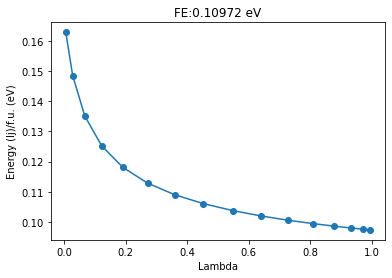

In [384]:
wait_for_jobs(job_ids_1)
fe_lj=integral(path_lj_on, lambda1,weight1,fu_num,'lj')


###finished###


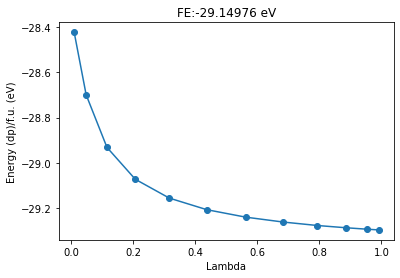

In [385]:
wait_for_jobs(job_ids_2)
fe_dp=integral(path_dp_on, lambda2,weight2,fu_num,'dp')


###finished###


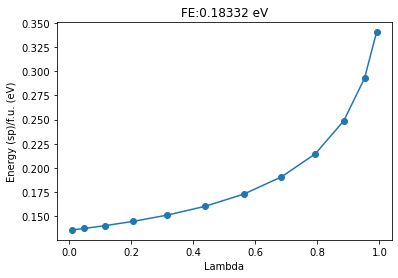

In [386]:
wait_for_jobs(job_ids_3)
fe_sp=integral(path_sp_off,lambda3,weight3,fu_num,'sp')

In [387]:
Helmholtz=A_cm+fe_lj+fe_dp-fe_sp
Gibbs=Helmholtz+pV
print(Helmholtz,Gibbs)
with open(f"{conf}/Free_energy.dat", "w") as f:
    f.write(f"A_cm: {A_cm} eV \n")
    f.write(f"LJ: {fe_lj} eV \n")
    f.write(f"DP: {fe_dp} eV \n")
    f.write(f"SP: {fe_sp} eV \n")
    f.write(f"pV: {pV} eV \n")    
    f.write(f"Helmholtz: {Helmholtz} eV \n")
    f.write(f"Gibbs: {Gibbs} eV \n")

-28.92227617515275 -28.44486505002865
